In [3]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
import warnings



In [4]:
def gen_deadline(exec_time, period,gen):
    # [a,b]
    b = 1.2 * period
    if(exec_time < 10):
        a = exec_time
    elif(exec_time < 100 and exec_time >= 10):
        a = 2*exec_time
    elif(exec_time < 1000 and exec_time >= 100):
        a = 3*exec_time
    else:
        a = 4*exec_time

    if(gen):
        a = 0.95*period
    return a+random.random()*(b-a)


def gen_tasksets(utilizations, periods,gen):

    def trunc(x, p):
        return int(x * 10 ** p) / float(10 ** p)
    # [[print(ui) for ui, pi in zip(us, ps)]
    #         for us, ps in zip(utilizations, periods)]
    return np.array([[[trunc(ui * pi, 6), trunc(pi, 6), trunc(gen_deadline(trunc(ui * pi, 6), trunc(pi, 6),gen), 6)] for ui, pi in zip(us, ps)]
            for us, ps in zip(utilizations, periods)])


In [5]:
def custom_period(n, nsets,max_,min_=1):
	max_power = np.log(max_)
	min_power = np.log(min_)

	intervals = np.arange(min_power,np.floor(max_power)+1)
	intervals = np.append(intervals, max_power)
	#print(intervals)
	task_pp = ((n-1)//(len(intervals)-1))
	
	task_lf = np.mod(n-1, len(intervals)-1).astype(int)
	#print(task_lf,task_pp)
	periods = np.zeros((nsets, n))
	for i in range(nsets):
		for j in range(len(intervals)-1):
			if(j<task_lf):
				periods[i][j*task_pp+j:(j+1)*task_pp+j+1] = np.random.uniform(low=np.exp(intervals[j]), high=np.exp(intervals[j+1]), size=task_pp+1)
			else:
				periods[i][j*task_pp+task_lf:(j+1)*task_pp+task_lf] = np.random.uniform(low=np.exp(intervals[j]), high=np.exp(intervals[j+1]), size=task_pp)
	periods[0:nsets,-1] =max_ 
	return periods


In [6]:
def UUniFastDiscard(n, u, nsets):
    sets = []
    while len(sets) < nsets:
        # Classic UUniFast algorithm:
        utilizations = []
        sumU = u
        for i in range(1, n):
            nextSumU = sumU * random.random() ** (1.0 / (n - i))
            utilizations.append(sumU - nextSumU)
            sumU = nextSumU
        utilizations.append(sumU)

        # If no task utilization exceeds 1:
        if all(ut <= 1 for ut in utilizations):
            sets.append(utilizations)

    return sets

    
def gen_uunifastdiscard(nsets, u, n):
    return UUniFastDiscard(n, u, nsets)

In [7]:
def get_taskset(nsets, n,t_max = 1000,util =0.9,gen=False):
	#n = 1000
	utilizations = gen_uunifastdiscard(nsets, util, n)
	periods = custom_period(n, nsets, t_max, 1)
	return gen_tasksets(utilizations, periods,gen)

	

In [8]:
taskset_paper = np.array([[6000, 18000, 31000], [2000, 9000, 9800], [1000, 12000, 17000], [
                         90, 3000, 4200], [8, 78, 96], [2, 16, 12], [10, 120, 280], [26, 160, 660]])


In [9]:
def procDemand_func(taskset,t):
    deadlines = taskset[:,1]
    periods = taskset[:,2]
    wcet = taskset[:,0]

    h_t = np.sum(np.maximum(0, 1 + np.floor((t-deadlines)/(periods)))*wcet)

    return h_t

In [10]:
def La_bound(taskset):
	"""
	Compute La calculations for the La bound
	
	"""
	wcet = taskset[:,0]
	deadlines = taskset[:,1]
	periods = taskset[:,2]
	utilizations = wcet/periods
	total_utilization = np.sum(utilizations)
	La = np.maximum(np.max(deadlines),np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
	return La


def Lb_bound(taskset):
    wcet = taskset[:,0]
    deadlines = taskset[:,1]
    periods = taskset[:,2]
    w0 = np.sum(wcet)
    a = w0
    b = np.sum(np.ceil(np.round((a/periods), 1)*wcet))
    while a != b and (((a**2 - b**2) > 0.0000001 or (b**2 - a**2) > 0.0000001)):
        #if (a**2 - b**2 > 0 and (np.sqrt(a**2 - b**2) > 0.0001)) or (a**2 - b**2 < 0 and (np.sqrt(b**2 - a**2) > 0.0001)):
        a = b
        b = np.round(np.sum(np.ceil(a/periods)*wcet), 1)
        
    Lb = b
    
    return Lb






In [11]:
def get_dmin(deadliness, L):
    return np.min(deadliness)
    

def get_max_abs_deadline(taskset, L):
    n = taskset.shape[0]
    abs_deadlines = []
    
    for i in range(n):
        p = 0
        j = 0
        Ti = taskset[i][2]
        Di = taskset[i][1]
        while p < L:
            j += 1
            q = p
            p = j*Ti + Di
            
        abs_deadlines.append(q)
    return np.max(abs_deadlines)
    
def get_max_di(taskset, t):
    n = taskset.shape[0]
    d_max = 0
    
    for j in range(n):
        if taskset[j][1] < t:
            d = np.floor((t - taskset[j][1])/taskset[j][2])*taskset[j][2] + taskset[j][1]
            if d == t:
                d = d - taskset[j][2]
            if d > d_max:
                d_max = d
                
    return d_max
    
    

In [12]:
def La_starbound(taskset):
	"""
	Compute La calculations for the La bound
	
	"""
	wcet = taskset[:, 0]
	deadlines = taskset[:, 1]
	periods = taskset[:, 2]
	utilizations = wcet/periods
	#print("deadlines", deadlines, "periods", periods, "utilizations", utilizations)
	#print(deadlines, periods, utilizations)
	total_utilization = np.sum(utilizations)
	#print("total utilization : " + str(total_utilization))
	# print(np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
	#La = np.maximum(np.max(deadlines),np.max((periods-deadlines))*(total_utilization/(1-total_utilization)))
	#print(np.max(deadlines))
	La_star = np.maximum(np.max(deadlines-periods),
	                np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
	return La_star


In [13]:
def La_starcalculations(taskset):
	La_star = La_starbound(taskset)
	
	wcet = taskset[:, 0]
	deadlines = taskset[:, 1]
	periods = taskset[:, 2]
	tot_abs_deadlines = 0
	for job in taskset:
		job_abs_deadline = 0
		if (job[1] <= job[2]):
			job_abs_deadline = np.floor((La_star)/job[2])
			if (job_abs_deadline*job[2]+job[1] <= La_star):
				job_abs_deadline = job_abs_deadline+1
		else:
			job_abs_deadline = np.floor((La_star)/job[2])
		while(job_abs_deadline*job[2]+job[1] > La_star):
				job_abs_deadline = job_abs_deadline-1
		job_abs_deadline+=1
		tot_abs_deadlines += job_abs_deadline
		#print(job_abs_deadline, job[1], job[2])
	return tot_abs_deadlines


In [14]:
def La_boundcalculations(taskset):
	La = La_bound(taskset)
	#print("La : " + str(La))
	wcet = taskset[:, 0]
	deadlines = taskset[:, 1]
	periods = taskset[:, 2]
	tot_abs_deadlines = 0
	for job in taskset:
		job_abs_deadline = 0
		if (job[1] <= job[2]):
			job_abs_deadline = np.floor((La-job[1])/job[2])
			while(job_abs_deadline*job[2]+job[1] < La):
				job_abs_deadline = job_abs_deadline+1
			job_abs_deadline-=1
		else:
			job_abs_deadline = np.floor((La-job[1])/job[2])

		while(job_abs_deadline*job[2]+job[1] > La):
				job_abs_deadline = job_abs_deadline-1
		job_abs_deadline+=1
		tot_abs_deadlines += job_abs_deadline

		
		
		#print(job_abs_deadline, job[1], job[2],(job_abs_deadline)*job[2]+job[1])
	#print(tot_abs_deadlines,str("total"))
	return tot_abs_deadlines


In [15]:
def Lb_boundcalculations(taskset):
	Lb = Lb_bound(taskset)
	wcet = taskset[:, 0]
	deadlines = taskset[:, 1]
	periods = taskset[:, 2]
	tot_abs_deadlines = 0
	#print(Lb)
	for job in taskset:
		job_abs_deadline = 0
		if (job[1] <= job[2]):
			job_abs_deadline = np.floor((Lb-job[1])/job[2])
			while(job_abs_deadline*job[2]+job[1] < Lb):
				job_abs_deadline = job_abs_deadline+1
			job_abs_deadline-=1

		else:
			job_abs_deadline = np.floor((Lb-job[1])/job[2])
		while(job_abs_deadline*job[2]+job[1] > Lb):
				job_abs_deadline = job_abs_deadline-1
		job_abs_deadline+=1
		tot_abs_deadlines += job_abs_deadline
		#print(job_abs_deadline, job[1], job[2])
	return tot_abs_deadlines


In [16]:
taskset_paper = np.array([[6000, 18000, 31000], [2000, 9000, 9800], [1000, 12000, 17000], [
                         90, 3000, 4200], [8, 78, 96], [2, 16, 12], [10, 120, 280], [26, 160, 660]])

print(La_starbound(taskset_paper),La_starcalculations(taskset_paper))
print(La_bound(taskset_paper),La_boundcalculations(taskset_paper))
print(Lb_bound(taskset_paper),Lb_boundcalculations(taskset_paper))

15356.96750813287 1523.0
18000.0 1784.0
16984.0 1685.0


In [17]:
taskset_paper = np.array([[6000, 18000, 31000], [2000, 9000, 9800], [1000, 12000, 17000], [
                         90, 3000, 4200], [8, 10, 96], [2, 16, 12], [10, 19, 280], [26, 160, 660]])

print(La_starbound(taskset_paper),La_starcalculations(taskset_paper))
print(La_bound(taskset_paper),La_boundcalculations(taskset_paper))
print(Lb_bound(taskset_paper),Lb_boundcalculations(taskset_paper))

15404.040376499068 1528.0
18000.0 1786.0
16984.0 1685.0


In [18]:
def qpa(taskset):

    La = La_bound(taskset)
    #print("La : " + str(La))
    Lb = Lb_bound(taskset)
    La_star = La_starbound(taskset)
    #print("Lb : " + str(La_star))
    L = min(La, Lb,La_star)
    #print("L : " + str(L))

    t = get_max_abs_deadline(taskset, L)
    #print("t : " + str(t))
    h_t = procDemand_func(taskset, t)
    #print("h(t) : " + str(h_t))
    d_min = get_dmin(taskset[:,1], L)


    total_cal = 0

    while (h_t := procDemand_func(taskset, t)) <= t and h_t > d_min:
        # h_t = procDemand_func(taskset, t)
        total_cal += 1

        #print("--t : " + str(t))
        #print("--h(t) : " + str(h_t))
        if h_t < t:
            t = h_t
        else:
            d_max = get_max_di(taskset, t)
            t = d_max

    if h_t <= d_min:
        #print("Task set is schedulable")
        #print("total calculations : " + str(total_cal))
        return total_cal+1
    else:
        #print("Task set is not schedulable")
        #print("total calculations : " + str(total_cal))
        return total_cal+1


## ht vs Number of Tasks

8 0
100
20 1
100
40 2
100
80 3
100
160 4
100
320 5
100
640 6
100
1280 7
100


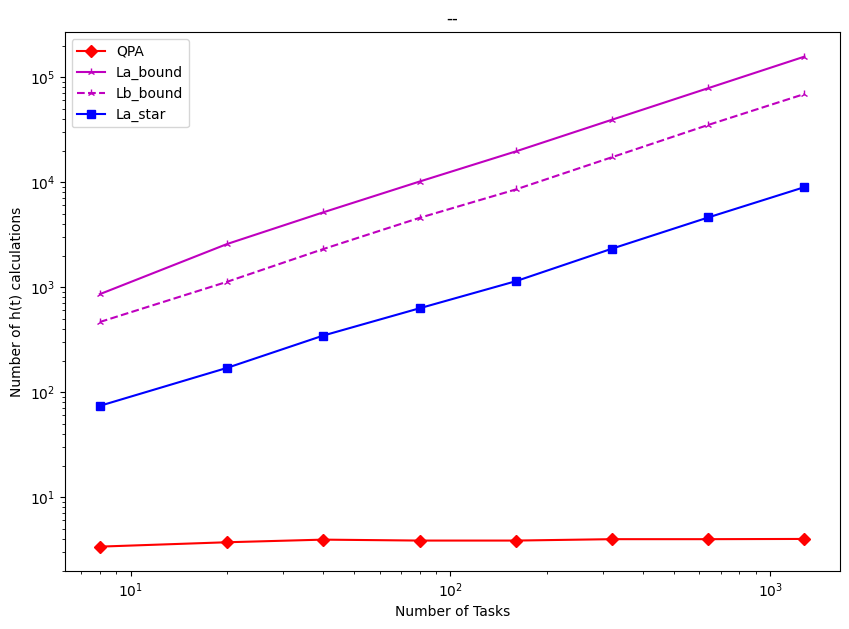

In [19]:
x = [8, 20, 40, 80, 160, 320, 640, 1280]
q = [0] * len(x)
la_cal = [0] * len(x)
lb_cal = [0] * len(x)
la_star_cal = [0] * len(x)
l = 0

for i in range(len(x)):
        print(x[i],i)
        taskset = get_taskset(100, int(x[i]),gen =True)
        total_count =0
        for j in range(len(taskset)):
            task = np.array(taskset[j])
            wcet = task[:, 0]
            deadlines = task[:, 1]
            periods = task[:, 2]
            
            utilizations = np.sum(wcet/np.minimum(periods, deadlines))
            if(utilizations<=1):
                ht_calculated = True
                total_count+=1
            else:
                #print("utilization is greater than 1")
                continue

            #print("utilization : " + str(utilizations))

            q[l] += qpa(task)

            la_cal[l] += La_boundcalculations(task)
            lb_cal[l] += Lb_boundcalculations(task)
            la_star_cal[l] += La_starcalculations(task)

        q[l]= q[l]/total_count
        la_cal[l] = la_cal[l]/total_count
        lb_cal[l] = lb_cal[l]/total_count
        la_star_cal[l] = la_star_cal[l]/total_count
        print(total_count)
        l += 1

# print(q)
# plt.plot(x, q)
# plt.plot(x, la_cal)
# plt.plot(x, lb_cal)

plt.figure(figsize=(10,7))
plt.plot(x,q,'-rD',label='QPA')
plt.plot(x,la_cal,'-m2',label='La_bound')
plt.plot(x,lb_cal,'--m2',label='Lb_bound')
plt.plot(x,la_star_cal,'-bs',label='La_star')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Number of Tasks')
plt.ylabel('Number of h(t) calculations')
plt.title("--")
plt.legend()
plt.show()


## h(t) vs Tmax/Tmin

10 0
100 1
1000 2
10000 3
100000 4
1000000 5


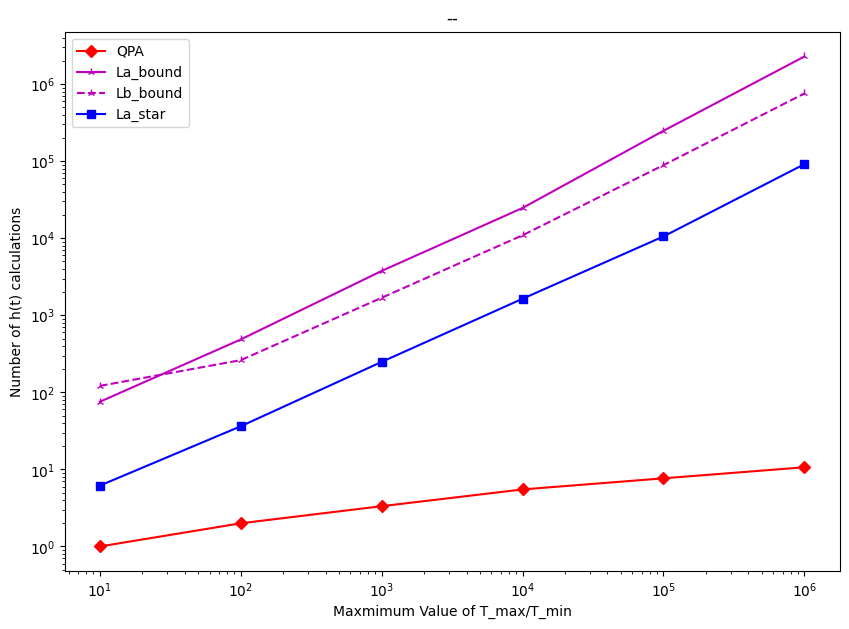

In [20]:
x = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
q = [0] * len(x)
la_cal = [0] * len(x)
lb_cal = [0] * len(x)
la_star_cal = [0] * len(x)
l = 0

for i in range(len(x)):
        print(x[i],i)
        taskset = get_taskset(6, 30,t_max=x[i],gen = True)
        total_count =0
        for j in range(len(taskset)):
            task = np.array(taskset[j])
            wcet = task[:, 0]
            deadlines = task[:, 1]
            periods = task[:, 2]
            
            utilizations = np.sum(wcet/np.minimum(periods, deadlines))
            if(utilizations<=1):
                ht_calculated = True
                total_count+=1
            else:
                #print("utilization is greater than 1")
                continue

            #print("utilization : " + str(utilizations))

            q[l] += qpa(task)

            la_cal[l] += La_boundcalculations(task)
            lb_cal[l] += Lb_boundcalculations(task)
            la_star_cal[l] += La_starcalculations(task)

        q[l]= q[l]/total_count
        la_cal[l] = la_cal[l]/total_count
        lb_cal[l] = lb_cal[l]/total_count
        la_star_cal[l] = la_star_cal[l]/total_count
        #print(total_count)
        l += 1

# print(q)
# plt.plot(x, q)
# plt.plot(x, la_cal)
# plt.plot(x, lb_cal)

plt.figure(figsize=(10,7))
plt.plot(x,q,'-rD',label='QPA')
plt.plot(x,la_cal,'-m2',label='La_bound')
plt.plot(x,lb_cal,'--m2',label='Lb_bound')
plt.plot(x,la_star_cal,'-bs',label='La_star')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Maxmimum Value of T_max/T_min')
plt.ylabel('Number of h(t) calculations')
plt.title("--")
plt.legend()
plt.show()

0.66 0
0.69 1
0.72 2
0.75 3
0.78 4
0.81 5
0.84 6
0.87 7
0.9 8
0.93 9
0.96 10
0.99 11


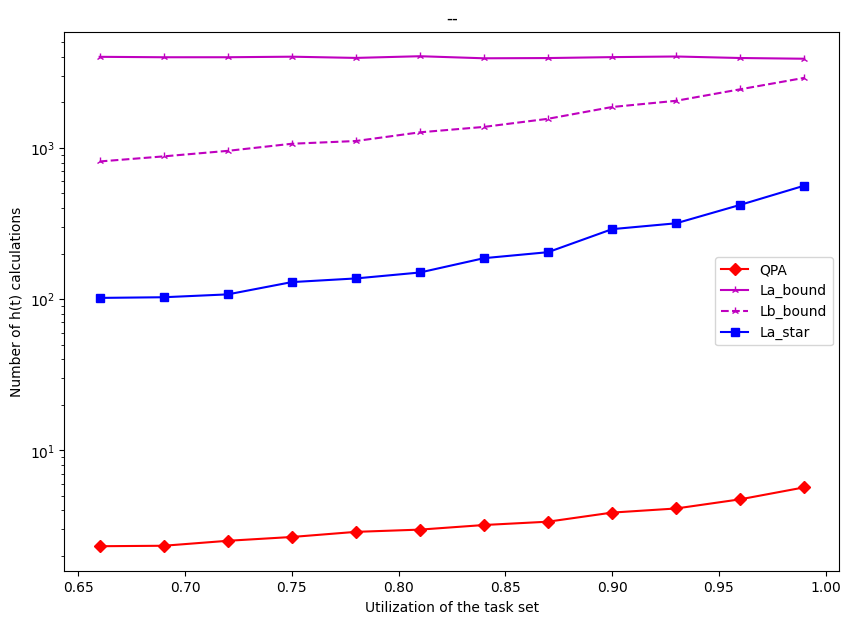

In [21]:
x = [0.66,0.69,0.72,0.75,0.78,0.81,0.84,0.87,0.9,0.93,0.96,0.99]
q = [0] * len(x)
la_cal = [0] * len(x)
lb_cal = [0] * len(x)
la_star_cal = [0] * len(x)
l = 0

for i in range(len(x)):
        print(x[i],i)
        taskset = get_taskset(60, 30,util = x[i],gen = True)
        total_count =0
        for j in range(len(taskset)):
            task = np.array(taskset[j])
            wcet = task[:, 0]
            deadlines = task[:, 1]
            periods = task[:, 2]
            
            utilizations = np.sum(wcet/np.minimum(periods, deadlines))
            if(utilizations<=1):
                ht_calculated = True
                total_count+=1
            else:
                #print("utilization is greater than 1")
                continue

            #print("utilization : " + str(utilizations))

            q[l] += qpa(task)

            la_cal[l] += La_boundcalculations(task)
            lb_cal[l] += Lb_boundcalculations(task)
            la_star_cal[l] += La_starcalculations(task)

        q[l]= q[l]/total_count
        la_cal[l] = la_cal[l]/total_count
        lb_cal[l] = lb_cal[l]/total_count
        la_star_cal[l] = la_star_cal[l]/total_count
        #print(total_count)
        l += 1

# print(q)
# plt.plot(x, q)
# plt.plot(x, la_cal)
# plt.plot(x, lb_cal)

plt.figure(figsize=(10,7))
plt.plot(x,q,'-rD',label='QPA')
plt.plot(x,la_cal,'-m2',label='La_bound')
plt.plot(x,lb_cal,'--m2',label='Lb_bound')
plt.plot(x,la_star_cal,'-bs',label='La_star')
plt.yscale("log")
plt.xlabel('Utilization of the task set')
plt.ylabel('Number of h(t) calculations')
plt.title("--")
plt.legend()
plt.show()


In [38]:
def old_method(taskset):
    wcet = task[:, 0]
    deadlines = task[:, 1]
    periods = task[:, 2]

    La = La_bound(taskset)
    #print("La : " + str(La))
    Lb = Lb_bound(taskset)
    La_star = La_starbound(taskset)
    #print("Lb : " + str(Lb))
    L = min(La, Lb,La_star)
    #print("L : " + str(L),La,Lb)

    t = get_max_abs_deadline(taskset, L)
    #print("t : " + str(t))
    h_t = procDemand_func(taskset, t)
    #print("h(t) : " + str(h_t))

    k=0
    deadline_n = k*periods + deadlines
    deadline_i = []
    total_cal = 0

    # while(np.min(deadline_n)<L):
    #     print(np.min(deadline_n),L,k)
    #     deadline_n = k*periods + deadlines
    #     k+=1
    #     for j in range(len(deadline_n)):
    #         if(deadline_n[j]<L and (deadline_n[j] not in deadline_i)):
    #             deadline_i.append(deadline_n[j])

    deadline_i = [0]
    #print("start")
    for job in taskset:
        job_abs_deadline = 0
        if (job[1] <= job[2]):
            job_abs_deadline = np.floor((L)/job[2])
            if (job_abs_deadline*job[2]+job[1] <= L):
                job_abs_deadline = job_abs_deadline+1
        else:
            job_abs_deadline = np.floor((La)/job[2])

        dead_s = np.arange(0,job_abs_deadline+1)*job[2]+job[1]
        #print(dead_s)
        deadline_i = np.concatenate((dead_s,np.array(deadline_i)))

    deadline_i[deadline_i>L] =0
    deadline_i = np.unique(deadline_i)
    deadline_i = np.sort(deadline_i)
    #print(np.max(deadline_i),deadline_i[2],len(deadline_i),L)
    #print(deadline_i)\\
    step =1
    next_deadline = deadline_i[0]
    caught = []
    j=0
    #print(len(deadline_i))
    while(j<len(deadline_i)-1):
        if(procDemand_func(taskset,deadline_i[j])>t):
            if(next_deadline in caught):
                break
            caught.append(next_deadline)
            j = np.argwhere(deadline_i> next_deadline-step)[0]
            next_deadline = deadline_i[j]
            while(len(np.argwhere(deadline_i> next_deadline+step))<=0):
                step = step/2
            j=np.argwhere(deadline_i> next_deadline+step)[0]
            next_deadline = deadline_i[j]
            #print(np.argwhere(deadline_i> next_deadline+step),step,next_deadline,caught,j,"hi")
            continue
            
        else:
            #print(np.argwhere(deadline_i> next_deadline+step),step,next_deadline,caught,j)
            if(len(np.argwhere(deadline_i> next_deadline+step)) >0):
                if( deadline_i[np.argwhere(deadline_i> next_deadline+step)[0]] != next_deadline):
                    j = np.argwhere(deadline_i> next_deadline+step)[0]
                    next_deadline = deadline_i[np.argwhere(deadline_i> next_deadline+step)[0]]
                    total_cal+=1
                    continue
                else:
                    break
            else:
                step = step/2
                continue

    #print(len(deadline_i),total_ca
    # 
    # l)

    
    return total_cal




In [40]:
x = [10, 20, 40, 80, 160, 320, 640, 1280]
q = [0] * len(x)
old_met = [0] * len(x)

l = 0

for i in range(len(x)):
        print(x[i],i)
        taskset = get_taskset(6, int(x[i]))
        total_count =0
        for j in range(len(taskset)):
            task = np.array(taskset[j])
            wcet = task[:, 0]
            deadlines = task[:, 1]
            periods = task[:, 2]
            
            utilizations = np.sum(wcet/np.minimum(periods, deadlines))
            if(utilizations<=1):
                
                continue

            else:
                ht_calculated = True
                total_count+=1

            #print("utilization : " + str(utilizations))

            q[l] += qpa(task)

            old_met[l] += old_method(task)


        q[l]= q[l]/total_count
        old_met[l] = old_met[l]/total_count
        print(total_count)
        l += 1

# print(q)
# plt.plot(x, q)
# plt.plot(x, la_cal)
# plt.plot(x, lb_cal)

plt.figure(figsize=(10,7))
plt.plot(x,q,'-rD',label='QPA')
plt.plot(x,old_met,'-bs',label='Old Method')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of h(t) calculations')
plt.title("Unschedulable Taskset")
plt.legend()
plt.show()


10 0


C:\Users\Rohan\AppData\Local\Temp\ipykernel_17116\2834955102.py:22: RuntimeWarning: overflow encountered in double_scalars
  while a != b and (((a**2 - b**2) > 0.0000001 or (b**2 - a**2) > 0.0000001)):
C:\Users\Rohan\AppData\Local\Temp\ipykernel_17116\2834955102.py:22: RuntimeWarning: invalid value encountered in double_scalars
  while a != b and (((a**2 - b**2) > 0.0000001 or (b**2 - a**2) > 0.0000001)):


6
20 1
6
40 2


KeyboardInterrupt: 

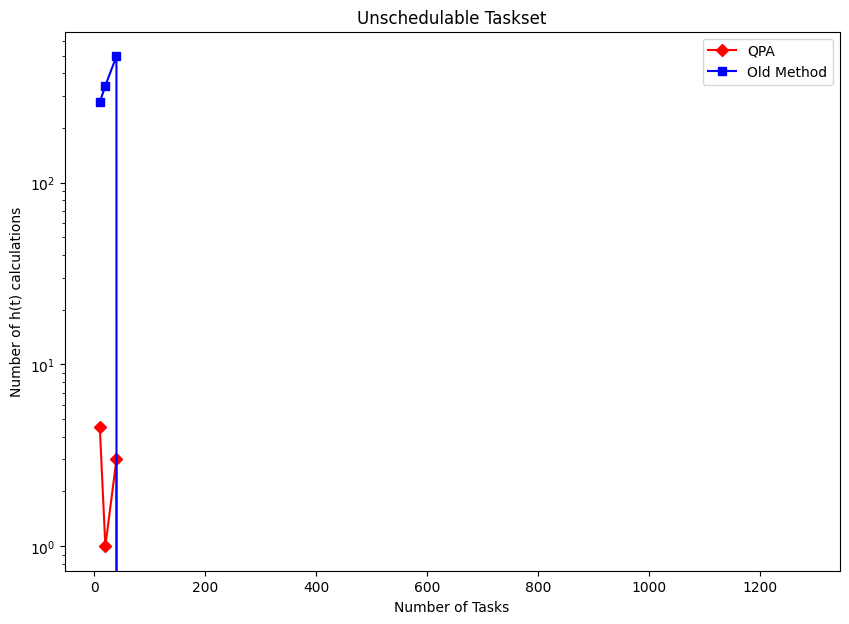

In [41]:
plt.figure(figsize=(10,7))
plt.plot(x,q,'-rD',label='QPA')
plt.plot(x,old_met,'-bs',label='Old Method')
plt.yscale("log")

plt.xlabel('Number of Tasks')
plt.ylabel('Number of h(t) calculations')
plt.title("Unschedulable Taskset")

plt.legend()
plt.show()


In [44]:
x = [500,1000,1500,2000,2500,3000,3500,4000]
q = [0] * len(x)
old_met = [0] * len(x)

l = 0

for i in range(len(x)):
        print(x[i],i)
        taskset = get_taskset(6, 30,t_max=x[i])
        total_count =0
        for j in range(len(taskset)):
            task = np.array(taskset[j])
            wcet = task[:, 0]
            deadlines = task[:, 1]
            periods = task[:, 2]
            
            utilizations = np.sum(wcet/np.minimum(periods, deadlines))
            if(utilizations<=1):
                
                continue

            else:
                ht_calculated = True
                total_count+=1

            #print("utilization : " + str(utilizations))

            q[l] += qpa(task)

            old_met[l] += old_method(task)


        q[l]= q[l]/total_count
        old_met[l] = old_met[l]/total_count
        print(total_count)
        l += 1

# print(q)
# plt.plot(x, q)
# plt.plot(x, la_cal)
# plt.plot(x, lb_cal)

plt.figure(figsize=(10,7))
plt.plot(x,q,'-rD',label='QPA')
plt.plot(x,old_met,'-bs',label='Old Method')
plt.yscale("log")
plt.xlabel('Maximum of Tmax/Tmin')
plt.ylabel('Number of h(t) calculations')
plt.title("Unschedulable Taskset")
plt.legend()
plt.show()


500 0


C:\Users\Rohan\AppData\Local\Temp\ipykernel_17116\2834955102.py:22: RuntimeWarning: overflow encountered in double_scalars
  while a != b and (((a**2 - b**2) > 0.0000001 or (b**2 - a**2) > 0.0000001)):
C:\Users\Rohan\AppData\Local\Temp\ipykernel_17116\2834955102.py:22: RuntimeWarning: invalid value encountered in double_scalars
  while a != b and (((a**2 - b**2) > 0.0000001 or (b**2 - a**2) > 0.0000001)):


6
1000 1


KeyboardInterrupt: 

0.66 0


C:\Users\Rohan\AppData\Local\Temp\ipykernel_18492\2834955102.py:22: RuntimeWarning: overflow encountered in double_scalars
  while a != b and (((a**2 - b**2) > 0.0000001 or (b**2 - a**2) > 0.0000001)):
C:\Users\Rohan\AppData\Local\Temp\ipykernel_18492\2834955102.py:22: RuntimeWarning: invalid value encountered in double_scalars
  while a != b and (((a**2 - b**2) > 0.0000001 or (b**2 - a**2) > 0.0000001)):


60
0.69 1
60
0.72 2
60
0.75 3
60
0.78 4
60
0.81 5
60
0.84 6
60
0.87 7
60
0.9 8
60
0.93 9
60
0.96 10
60
0.99 11
60


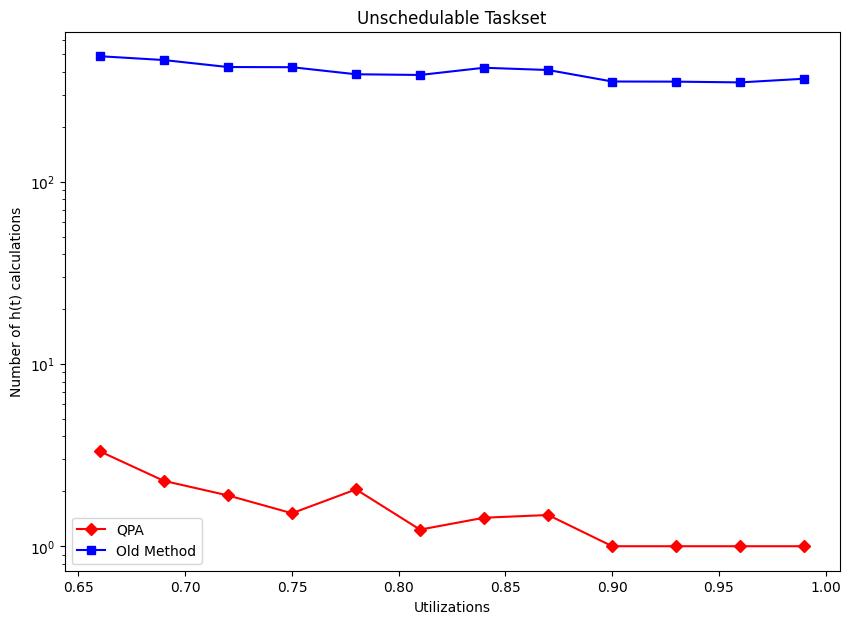

In [ ]:
x = [0.66,0.69,0.72,0.75,0.78,0.81,0.84,0.87,0.9,0.93,0.96,0.99]
q = [0] * len(x)
old_met = [0] * len(x)

l = 0

for i in range(len(x)):
        print(x[i],i)
        taskset = get_taskset(60, 30,util = x[i])
        total_count =0
        for j in range(len(taskset)):
            task = np.array(taskset[j])
            wcet = task[:, 0]
            deadlines = task[:, 1]
            periods = task[:, 2]
            
            utilizations = np.sum(wcet/np.minimum(periods, deadlines))
            if(utilizations<=1):
                
                continue

            else:
                ht_calculated = True
                total_count+=1

            #print("utilization : " + str(utilizations))

            q[l] += qpa(task)

            old_met[l] += old_method(task)


        q[l]= q[l]/total_count
        old_met[l] = old_met[l]/total_count
        print(total_count)
        l += 1

# print(q)
# plt.plot(x, q)
# plt.plot(x, la_cal)
# plt.plot(x, lb_cal)

plt.figure(figsize=(10,7))
plt.plot(x,q,'-rD',label='QPA')
plt.plot(x,old_met,'-bs',label='Old Method')
plt.yscale("log")
plt.xlabel("Utilizations")
plt.ylabel('Number of h(t) calculations')
plt.title("Unschedulable Taskset")
plt.legend()
plt.show()